# Make segmentation test data

Let's make some data to test segmentation for Poisson observations.

In [1]:
using Distributions

In [2]:
srand(12345);

## Set up constants

In [3]:
# duration stuff

T = 50  # total duration (in s)
dt = 0.05  # bin size (in s)
Nt = ceil(Int64, T / dt)

μ = 0.5  # mean state duration (in s)
σ = 0.05  # standard deviation of state duration (in s)

0.05

In [4]:
# rates
λ = 10.  # baseline rate (Hz)
ν = 5.  # rate multiplier (Hz)

5.0

## Make some intervals

In [5]:
durations = μ + σ * randn(Nt)
changepoints = cumsum(durations)
maxind = findlast(x -> x < T, changepoints)
changepoints = changepoints[1:maxind];

In [6]:
taxis = dt:dt:T
states = zeros(Float64, Nt)
rates = fill(λ, Nt)

for idx in 2:2:(length(changepoints) - 1)
    in_state_1 = changepoints[idx] .< taxis .< changepoints[idx + 1]
    states[in_state_1] = 1
    rates[in_state_1] = ν * λ
end

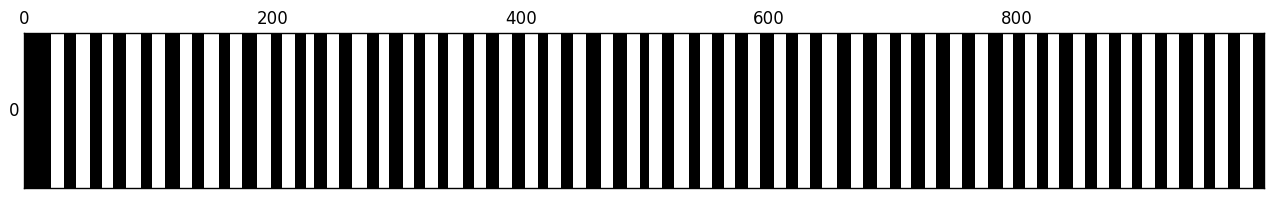

In [7]:
using PyPlot

matshow(states', cmap="gray", aspect="auto");

## Make counts

In [8]:
urates = unique(rates)
dists = [r => Poisson(r * dt) for r in urates]

Dict{Any,Distributions.Poisson} with 2 entries:
  10.0 => Distributions.Poisson(λ=0.5)
  50.0 => Distributions.Poisson(λ=2.5)

In [9]:
counts = Array(Int64, Nt)

for r in urates
    selection = rates .== r
    counts[selection] = rand(dists[r], sum(selection))
end

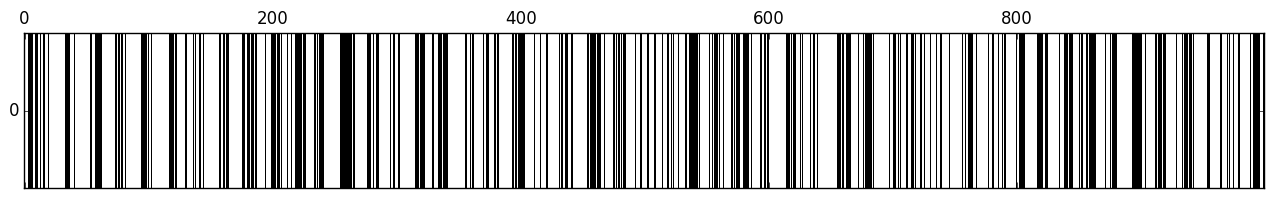

In [10]:
matshow(counts', cmap="gray", aspect="auto", clim=(0, 1));

In [11]:
using HDF5

fid = h5open("data/basic_poisson_test.jld", "w")

grp = fid["/"]
grp["counts"] = counts
grp["rates"] = rates
grp["states"] = states
grp["base_rate"] = λ
grp["rate_gain"] = ν
grp["bin_width"] = dt

close(fid)